In [316]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [280]:
wncaa=pd.read_csv("wnba.csv", index_col=0)
wncaa=wncaa.reset_index(drop=True)

In [281]:
wncaa.head()

,TeamID,Season,games,totalMargin,Wins,Losses,Points,FG,FGA,FG3,FGA3,FT,FTA,OR,DR,Ast,To,Stl,Blk,Pf
0,3102.0,2010.0,28,-19.964286,1,27,51.821429,19.142857,53.142857,4.571429,16.071429,8.964286,13.214286,12.464286,19.535714,10.250000,17.714286,6.035714,0.642857,14.964286
1,3103.0,2010.0,30,2.600000,17,13,62.233333,22.233333,55.266667,3.933333,12.466667,13.833333,19.600000,14.200000,23.566667,13.433333,18.266667,8.033333,2.400000,17.533333
2,3104.0,2010.0,29,-2.862069,11,18,64.137931,24.724138,62.103448,4.344828,14.724138,10.344828,16.793103,14.482759,25.931034,13.103448,19.172414,7.379310,2.931034,20.413793
3,3105.0,2010.0,27,-3.962963,14,13,60.777778,20.370370,50.851852,3.037037,9.888889,17.000000,24.333333,13.666667,23.370370,9.740741,25.037037,8.777778,5.148148,19.148148
4,3106.0,2010.0,29,-2.275862,12,17,55.137931,18.448276,53.000000,2.689655,9.586207,15.551724,24.000000,15.000000,24.758621,11.482759,20.103448,8.034483,4.482759,22.068966


In [282]:
tourn = pd.read_csv("google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneyDetailedResults.csv")

In [283]:
sample=pd.read_csv("google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv")

In [284]:
id = sample["ID"].str.split("_", n = 2, expand = True)

In [285]:
sample["Season"] = id[0]
sample ["Team1"] = id[1]
sample ["Team2"] = id[2]


In [286]:
tourn2 = tourn[["Season", "WTeamID", "LTeamID", "WScore", "LScore"]]
tourn2["Result"]=1

/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [379]:
cols=['games', 'totalMargin', 'Wins', 'Losses', 'Points',
       'FG', 'FGA', 'FG3', 'FGA3', 'FT', 'FTA', 'OR', 'DR', 'Ast', 'To', 'Stl',
       'Blk', 'Pf', 'Seed']
team1=['games_x', 'totalMargin_x', 'Wins_x', 'Losses_x',
       'Points_x', 'FG_x', 'FGA_x', 'FG3_x', 'FGA3_x', 'FT_x', 'FTA_x', 'OR_x',
       'DR_x', 'Ast_x', 'To_x', 'Stl_x', 'Blk_x', 'Pf_x', 'Seed_x']

team2=[
       'games_y', 'totalMargin_y', 'Wins_y', 'Losses_y', 'Points_y', 'FG_y',
       'FGA_y', 'FG3_y', 'FGA3_y', 'FT_y', 'FTA_y', 'OR_y', 'DR_y', 'Ast_y',
       'To_y', 'Stl_y', 'Blk_y', 'Pf_y', 'Seed_y']

In [369]:
import random
random.seed(42)
rand = random.sample(range(0,63), 30)
seasons = tourn2.Season.unique()

def cleanTourn():
    clean = pd.DataFrame()
    for season in seasons:
        to = tourn2[tourn2["Season"]==season]
        to=to.reset_index()
        for num in rand:
            to.loc[num,["WTeamID", "LTeamID"]] = to.loc[num, ["LTeamID", "WTeamID"]].values
            to.loc[num,["WScore", "LScore"]] = to.loc[num, ["LScore", "WScore"]].values
            to.loc[num,["Result"]] = 0
        clean=pd.concat([clean,to])
    clean=clean.rename(columns={"WTeamID": "Team1", "LTeamID": "Team2", "WScore": "Team1Score", "LScore": "Team2Score"})
    clean=clean[["Season", "Team1", "Team2", "Team1Score", "Team2Score", "Result"]]
    return clean
train=cleanTourn()


In [370]:
path = "google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/"
seeds = pd.read_csv(path + 'WNCAATourneySeeds.csv')
def get_seed(x):
    return int(x[1:3])

In [372]:
train=pd.merge(train, wncaa, left_on=["Season", "Team1"], right_on=["Season", "TeamID"])
train=pd.merge(train, wncaa, left_on=["Season", "Team2"], right_on=["Season", "TeamID"])

In [373]:
train=pd.merge(train, seeds, left_on=["Season", "Team1"], right_on =["Season", "TeamID"]).drop("TeamID", axis=1)
train=pd.merge(train, seeds, left_on=["Season", "Team2"], right_on =["Season", "TeamID"]).drop("TeamID", axis=1)

In [374]:
train["Seed_x"] = train["Seed_x"].map(lambda x: get_seed(x))
train["Seed_y"] = train["Seed_y"].map(lambda x: get_seed(x))

In [376]:
sample[["Season", "Team1", "Team2"]] = sample[["Season", "Team1", "Team2"]].apply(pd.to_numeric)

In [387]:
test = pd.merge(sample, wncaa, left_on=["Season", "Team1"], right_on = ["Season", "TeamID"])
test = pd.merge(test, wncaa, left_on=["Season", "Team2"], right_on = ["Season", "TeamID"])
test=pd.merge(test, seeds, left_on=["Season", "Team1"], right_on =["Season", "TeamID"]).drop("TeamID", axis=1)
test=pd.merge(test, seeds, left_on=["Season", "Team2"], right_on =["Season", "TeamID"]).drop("TeamID", axis=1)
test["Seed_x"] = test["Seed_x"].map(lambda x: get_seed(x))
test["Seed_y"] = test["Seed_y"].map(lambda x: get_seed(x))

def cleanTest():
    featureSpace = ["Season", "Team1", "Team2"]
    for i in range(len(team1)):
        colname = "diff_" + cols[i]
        test[colname]=test[team1[i]] - test[team2[i]]
        featureSpace.append(colname)
    return test[featureSpace]

In [389]:
def cleanTrain():
    featureSpace = ["Season", "Team1", "Team2", "Result"]
    for i in range(len(team1)):
        colname = "diff_" + cols[i]
        train[colname]=train[team1[i]] - train[team2[i]]
        featureSpace.append(colname)
    return train[featureSpace]

In [390]:
cleanTrain=cleanTrain()

In [391]:
cleanTest=cleanTest()

In [392]:
result = train.Result

In [393]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
features=['diff_totalMargin',
       'diff_Wins', 'diff_Losses', 'diff_Points', 'diff_FG', 'diff_FGA',
       'diff_FG3', 'diff_FGA3', 'diff_FT', 'diff_FTA', 'diff_OR', 'diff_DR',
       'diff_Ast', 'diff_To', 'diff_Stl', 'diff_Blk', 'diff_Pf', "diff_Seed"]


In [394]:
log.fit(cleanTrain[cleanTrain["Season"]<2015][features], cleanTrain[cleanTrain["Season"]<2015]["Result"])

/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [395]:
predictions = log.predict_proba(cleanTest[features])

In [415]:
log.fit(cleanTrain[cleanTrain["Season"]<2015][["diff_Seed"]], cleanTrain[cleanTrain["Season"]<2015]["Result"])

/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [416]:
pred2 = log.predict_proba(cleanTest[["diff_Seed"]])

In [327]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import gc

In [402]:
params_lgb = {'num_leaves': 400,
              'min_child_weight': 0.034,
              'feature_fraction': 0.379,
              'bagging_fraction': 0.418,
              'min_data_in_leaf': 106,
              'objective': 'binary',
              'max_depth': 50,
              'learning_rate': 0.0068,
              "boosting_type": "gbdt",
              "bagging_seed": 11,
              "metric": 'logloss',
              "verbosity": -1,
              'reg_alpha': 0.3899,
              'reg_lambda': 0.648,
              'random_state': 47,
              }

In [403]:
from sklearn.model_selection import KFold
NFOLDS = 200
folds = KFold(n_splits=NFOLDS)

splits = folds.split(cleanTrain[cleanTrain["Season"]<2015][features], cleanTrain[cleanTrain["Season"]<2015]["Result"])


In [404]:
y_preds_lgb = np.zeros(cleanTest.shape[0])
y_oof_lgb = np.zeros(cleanTrain[cleanTrain["Season"]<2015][features].shape[0])


In [405]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train1, X_valid1 = cleanTrain[cleanTrain["Season"]<2015][features].iloc[train_index], cleanTrain[cleanTrain["Season"]<2015][features].iloc[valid_index]
    y_train1, y_valid1 = cleanTrain[cleanTrain["Season"]<2015]["Result"].iloc[train_index], cleanTrain[cleanTrain["Season"]<2015]["Result"].iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train1, label=y_train1)
    dvalid = lgb.Dataset(X_valid1, label=y_valid1)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    y_pred_valid = clf.predict(X_valid1)
    y_oof_lgb[valid_index] = y_pred_valid
    
    y_preds_lgb += clf.predict(cleanTest[features]) / NFOLDS
    
    del X_train1, X_valid1, y_train1, y_valid1
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49
Fold: 50
Fold: 51
Fold: 52
Fold: 53
Fold: 54
Fold: 55
Fold: 56
Fold: 57
Fold: 58
Fold: 59
Fold: 60
Fold: 61
Fold: 62
Fold: 63
Fold: 64
Fold: 65
Fold: 66
Fold: 67
Fold: 68
Fold: 69
Fold: 70
Fold: 71
Fold: 72
Fold: 73
Fold: 74
Fold: 75
Fold: 76
Fold: 77
Fold: 78
Fold: 79
Fold: 80
Fold: 81
Fold: 82
Fold: 83
Fold: 84
Fold: 85
Fold: 86
Fold: 87
Fold: 88
Fold: 89
Fold: 90
Fold: 91
Fold: 92
Fold: 93
Fold: 94
Fold: 95
Fold: 96
Fold: 97
Fold: 98
Fold: 99
Fold: 100
Fold: 101
Fold: 102
Fold: 103
Fold: 104
Fold: 105
Fold: 106
Fold: 107
Fold: 108
Fold: 109
Fold: 110
Fold: 11

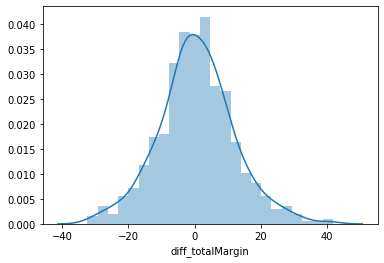

In [318]:
sns.distplot(cleanTrain.diff_totalMargin)

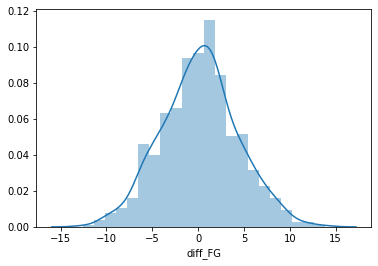

In [322]:
sns.distplot(cleanTrain.diff_FG)

In [396]:
sample2=pd.read_csv("google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv")

In [399]:
predictions[:,1]

array([0.02400409, 0.05523469, 0.68368882, ..., 0.42414495, 0.55662103,
       0.97534827])

In [400]:
sample2.Pred =predictions[:,1]

In [401]:
sample2.to_csv("wnba_log.csv", index=False)

In [406]:
sample2.Pred=y_preds_lgb
sample2.to_csv("wnba_lgb.csv", index=False)

In [407]:
y_preds_lgb

array([0.06097815, 0.24282488, 0.79877817, ..., 0.17724596, 0.37674807,
       0.97281612])

In [408]:
sample2.Pred = (predictions[:,1]+y_preds_lgb)/2
sample2.to_csv("wnba_ensemble.csv", index=False)

In [417]:
sample2.Pred = pred2[:,1]
sample2.to_csv("wnba_simple_log.csv", index=False)

In [418]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(cleanTrain[cleanTrain["Season"]<2015][features])

In [419]:
log.fit(X_std, cleanTrain[cleanTrain["Season"]<2015]["Result"])

/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [420]:
predictions = log.predict_proba(scaler.fit_transform(cleanTest[features]))

In [421]:
sample2.Pred =predictions[:,1]
sample2.to_csv("wnba_log.csv", index=False)

In [426]:
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(solver="lbfgs")
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(cleanTrain[cleanTrain["Season"]<2015][features], cleanTrain[cleanTrain["Season"]<2015]["Result"])
print('Best log_loss: {:.5}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best log_loss: -0.40405, with best C: 0.01


In [427]:
preds=clf.predict_proba(cleanTest[features])[:,1]
clipped_preds = np.clip(preds, 0.05, 0.95)

In [428]:
sample2.Pred =clipped_preds
sample2.to_csv("wnba_log.csv", index=False)

In [437]:
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": 0.005,
          "num_leaves": 31,
          "min_data_in_leaf": 10,
          "min_child_samples": 10,
          }

dtrain = lgb.Dataset(X_std, cleanTrain[cleanTrain["Season"]<2015]["Result"])
#dvalid = lgb.Dataset(X_val, y_val, reference=dtrain)
bst = lgb.train(params, dtrain, 1000, verbose_eval=200)

In [438]:
lgbPred=bst.predict(
    scaler.fit_transform(cleanTest[features]), num_iteration=bst.best_iteration)
lgbClip=np.clip(lgbPred, 0.05, 0.95)
sample2.Pred =lgbClip
sample2.to_csv("wnba_lgb.csv", index=False)

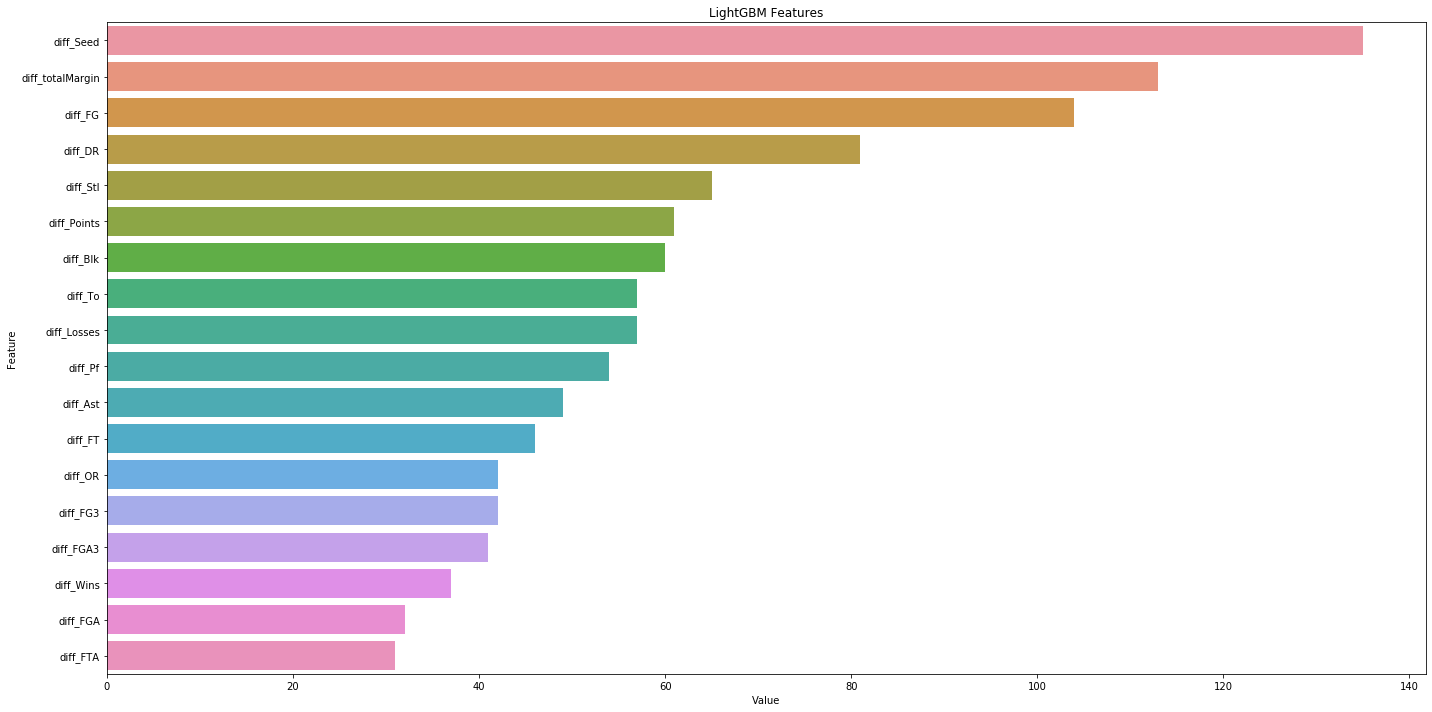

In [436]:
import matplotlib.pyplot as plt
lgbModel=lgb.LGBMModel(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,n_estimators=100, subsample_for_bin=200000, objective="binary")

lgbModel.fit(cleanTrain[cleanTrain["Season"]<2015][features], cleanTrain[cleanTrain["Season"]<2015]["Result"])
feature_imp = pd.DataFrame(sorted(zip(lgbModel.feature_importances_,features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()